In [2]:
from icet import ClusterExpansion
from icet.tools.structure_generation import occupy_structure_randomly

ce = ClusterExpansion.read("../../production_rocksalts/AllRocksalts/LMOF/CEFitting/FittingFiles/cluster_expansion.ce")
prim = ce.primitive_structure
prim = prim.repeat(6)
occupy_structure_randomly(prim, ce.get_cluster_space_copy(), {"B" : {"Mn" : 1/3, "Li": 2/3}, "A" : {"O" : 1, "F": 0}})

from mchammer.calculators import ClusterExpansionCalculator
from mchammer.ensembles import CanonicalEnsemble
from observers import PercolationObserver, NTMObserver, LocalEnvObserver
from ase import  Atom
from icet.tools import map_structure_to_reference

def get_tetra_centers(atoms, prim):
    prim.append(Atom("X"))
    prim.append(Atom("X"))
    prim.set_scaled_positions([[0, 0, 0], [0.5, 0.5, 0.5], [0.25, 0.25, 0.25], [0.75, 0.75, 0.75]])
     
    inert_species = list(set(atoms.symbols))
    mapping = map_structure_to_reference(atoms, prim, inert_species=inert_species)[0]
    tetra_centres = [i.position for i in mapping if i.symbol == "X"]
    return tetra_centres

s = get_tetra_centers(prim, ce.primitive_structure)
ce_calc = ClusterExpansionCalculator(prim, ce)
mc = CanonicalEnsemble(prim, ce_calc, temperature = 1273)
mc.attach_observer(PercolationObserver(prim, s, background_species=["O", "F"]))
# mc.attach_observer(NTMObserver(prim, s, background_species=["O", "F"]))
mc.attach_observer(LocalEnvObserver(prim, []))







icet: WARNING  High volumetric strain (-75.00 %). Consider excluding this structure when training a cluster expansion.
icet: WARNING  Large average relaxation distance (0.76906 Angstrom). Consider excluding this structure when training a cluster expansion.


/Users/alex/work/tracy/tracy/localenv.py:119: UserWarning: Some of the tetrahedral sites does not have four closest neiboroughs.
  warnings.warn(


In [3]:
mc.run(500)

IndexError: index 1670 is out of bounds for axis 0 with size 432

In [5]:
print(prim.symbols)

OLiOMnOLiOLiOLiOLiOLiOLiOLiOLiOLiOMnOLiOLiOLiOLiOLiOLiOLiOMnOLiOLiOMnOMnOMnOLiOMnOLiOLiOLiOLiOLiOLiOMnOMnOMnOLiOMnOLiOLiOLiOLiOLiOMnOLiOLiOLiOLiOLiOLiOLiOMnOLiOLiOLiOLiOMnOMnOLiOLiOLiOMnOMnOLiOLiOLiOMnOLiOMnOMnOLiOMnOMnOLiOMnOLiOMnOLiOLiOMnOMnOLiOLiOLiOLiOMnOLiOLiOLiOLiOLiOLiOMnOLiOLiOMnOLiOMnOMnOMnOLiOLiOLiOLiOLiOLiOMnOLiOMnOLiOLiOLiOLiOLiOLiOLiOLiOLiOLiOMnOLiOMnOMnOLiOMnOLiOLiOLiOMnOLiOLiOLiOMnOMnOMnOLiOMnOMnOMnOMnOMnOLiOLiOLiOLiOLiOLiOMnOLiOLiOMnOLiOMnOLiOMnOMnOLiOMnOMnOLiOLiOLiOLiOLiOLiOLiOMnOMnOLiOLiOLiOMnOLiOMnOLiOMnOLiOMnOMnOMnOLiOMnOLiOLiOMnOLiOMnOLiOLiOLiOLiOLiOLiOMnOLiOMnOMnOMnOLiOMnOMnOLiOLiOLiOLiOLiOLiOLiOLiOLiOLiOLiOLiOLiOLiOMn


In [256]:
from ase.io import read
from ase.neighborlist import build_neighbor_list
from collections import Counter

structure = read("/Users/alex/Downloads/extended.xyz")



def build_tetra_centre_nn(atoms, bkg = [8,9], cutoff=2) -> list[int]:
    """
    Build NN mapping for the surrounding tetrahedral sites

    Args:
        atoms (ase.Atoms): Input template Atoms

    Returns:
        a dictionary with keys being the indices of the cation site and values
        being list of the neighbors.
    """

    extended_atoms = atoms

    cutoffs = [
        0.01 if atom.symbol in bkg else cutoff / 2 for atom in atoms
    ]
    # Build the NN list for the extended atoms
    nlist = build_neighbor_list(extended_atoms, cutoffs=cutoffs, bothways=True)

    int_sites = [i for i in structure if i.symbol == "X"]

    tetra_sites = {atom.index : {} for atom in int_sites}
    numbers = extended_atoms.numbers
    for atom in int_sites:
        nnlist = nlist.get_neighbors(atom.index)[0].tolist()
        only_cation = []
        for nidx in nnlist:
            # Add the index of the atoms if it satisfy the condition
            if (
                numbers[nidx]
                not in bkg  # Not a background ion
                and nidx != atom.index  # Not myself
                and extended_atoms.get_distance(nidx, atom.index, mic=True)
                < cutoff
            ):  # Lower than the cut off
                only_cation.append(nidx)
            # Use the position vector of the tetrahedral site as the key for the dictionary
        tetra_tm = len([atoms[i].number for i in only_cation if i == 3])
        tetra_sites[atom.index]["bonded_to"] = only_cation
        tetra_sites[atom.index]["n_TM"] = tetra_tm

    return tetra_sites

a = build_tetra_centre_nn(structure)



{54: {'bonded_to': [1, 5, 13, 37], 'n_TM': 0}, 55: {'bonded_to': [1, 3, 7, 19], 'n_TM': 1}, 56: {'bonded_to': [1, 3, 15, 39], 'n_TM': 1}, 57: {'bonded_to': [3, 5, 9, 21], 'n_TM': 1}, 58: {'bonded_to': [3, 5, 17, 41], 'n_TM': 1}, 59: {'bonded_to': [1, 5, 11, 23], 'n_TM': 0}, 60: {'bonded_to': [1, 7, 11, 43], 'n_TM': 0}, 61: {'bonded_to': [7, 9, 13, 25], 'n_TM': 0}, 62: {'bonded_to': [3, 7, 9, 45], 'n_TM': 1}, 63: {'bonded_to': [9, 11, 15, 27], 'n_TM': 0}, 64: {'bonded_to': [5, 9, 11, 47], 'n_TM': 0}, 65: {'bonded_to': [7, 11, 17, 29], 'n_TM': 0}, 66: {'bonded_to': [7, 13, 17, 49], 'n_TM': 0}, 67: {'bonded_to': [1, 13, 15, 31], 'n_TM': 0}, 68: {'bonded_to': [9, 13, 15, 51], 'n_TM': 0}, 69: {'bonded_to': [3, 15, 17, 33], 'n_TM': 1}, 70: {'bonded_to': [11, 15, 17, 53], 'n_TM': 0}, 71: {'bonded_to': [13, 5, 17, 35], 'n_TM': 0}, 72: {'bonded_to': [1, 19, 23, 31], 'n_TM': 0}, 73: {'bonded_to': [19, 21, 25, 37], 'n_TM': 0}, 74: {'bonded_to': [3, 19, 21, 33], 'n_TM': 1}, 75: {'bonded_to': [21, 

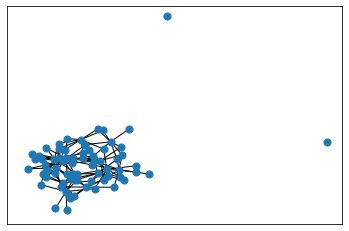

In [199]:
import matplotlib.pyplot as plt
nx.draw_networkx(G, with_labels=False, node_size = 50)
plt.show()

[1, 33, 65, 101, 69, 73, 9, 77, 13, 45, 17, 49, 53, 89, 57]


False

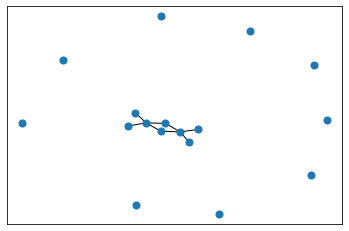

In [202]:
SG = G.subgraph([n for n in G.nodes if G.nodes[n]["n_TM"] == "Li" or G.nodes[n]["n_TM"] == 0])
nx.draw_networkx(SG, with_labels=False, node_size = 50)

print([node for node in SG.nodes if SG.nodes[node]["n_TM"] == "Li"])
nx.has_path(SG, 1, 9)

In [206]:
for i in nx.connected_components(SG):
    print(i)

{1}
{89, 65, 33, 69, 70, 53, 55, 57}
{101}
{73}
{9}
{77}
{13}
{45}
{17}
{49}


In [248]:
structure
graph = nx.MultiDiGraph()
graph.add_nodes_from(range(len(structure)))

new_structure = structure.repeat(2)
mapping = {n : n + len(new_structure) for n in range(len(tet_structure))}

print(mapping)
# graph.nodes
# nx.readwrite.json_graph.adjacency_data(graph)

# def add_edge(u, v, j_u, j_v):
#     if u < v:
#         u , v = v, u
#         j_u, j_v = j_v, j_u
    
#     if not np.array_equal(j_v, [0,0,0]):
#         shift = j_v
#         j_v = np.subtract(j_v, shift)
#         j_u = np.add(j_u, shift)


{0: 432, 1: 433, 2: 434, 3: 435, 4: 436, 5: 437, 6: 438, 7: 439, 8: 440, 9: 441, 10: 442, 11: 443, 12: 444, 13: 445, 14: 446, 15: 447, 16: 448, 17: 449, 18: 450, 19: 451, 20: 452, 21: 453, 22: 454, 23: 455, 24: 456, 25: 457, 26: 458, 27: 459, 28: 460, 29: 461, 30: 462, 31: 463, 32: 464, 33: 465, 34: 466, 35: 467, 36: 468, 37: 469, 38: 470, 39: 471, 40: 472, 41: 473, 42: 474, 43: 475, 44: 476, 45: 477, 46: 478, 47: 479, 48: 480, 49: 481, 50: 482, 51: 483, 52: 484, 53: 485, 54: 486, 55: 487, 56: 488, 57: 489, 58: 490, 59: 491, 60: 492, 61: 493, 62: 494, 63: 495, 64: 496, 65: 497, 66: 498, 67: 499, 68: 500, 69: 501, 70: 502, 71: 503, 72: 504, 73: 505, 74: 506, 75: 507, 76: 508, 77: 509, 78: 510, 79: 511, 80: 512, 81: 513, 82: 514, 83: 515, 84: 516, 85: 517, 86: 518, 87: 519, 88: 520, 89: 521, 90: 522, 91: 523, 92: 524, 93: 525, 94: 526, 95: 527, 96: 528, 97: 529, 98: 530, 99: 531, 100: 532, 101: 533, 102: 534, 103: 535, 104: 536, 105: 537, 106: 538, 107: 539}


In [250]:


structure.repeat(2)
pos = [p for p in structure.get_positions()]

new_sites = []
new_graphs = []
for p in pos:
    mapping = {n : n + len(new_sites) for n in range(len(tet_structure))}
    new_sites.append(p)
    new_graphs.append(nx.relabel_nodes(G, mapping, copy=True))

nx.union_all(new_graphs + [graph])

NetworkXError: ('The node sets of the graphs are not disjoint.', 'Use appropriate rename=(G1prefix,G2prefix,...,GNprefix)or use disjoint_union(G1,G2,...,GN).')

In [252]:
mapping

{0: 53,
 1: 54,
 2: 55,
 3: 56,
 4: 57,
 5: 58,
 6: 59,
 7: 60,
 8: 61,
 9: 62,
 10: 63,
 11: 64,
 12: 65,
 13: 66,
 14: 67,
 15: 68,
 16: 69,
 17: 70,
 18: 71,
 19: 72,
 20: 73,
 21: 74,
 22: 75,
 23: 76,
 24: 77,
 25: 78,
 26: 79,
 27: 80,
 28: 81,
 29: 82,
 30: 83,
 31: 84,
 32: 85,
 33: 86,
 34: 87,
 35: 88,
 36: 89,
 37: 90,
 38: 91,
 39: 92,
 40: 93,
 41: 94,
 42: 95,
 43: 96,
 44: 97,
 45: 98,
 46: 99,
 47: 100,
 48: 101,
 49: 102,
 50: 103,
 51: 104,
 52: 105,
 53: 106,
 54: 107,
 55: 108,
 56: 109,
 57: 110,
 58: 111,
 59: 112,
 60: 113,
 61: 114,
 62: 115,
 63: 116,
 64: 117,
 65: 118,
 66: 119,
 67: 120,
 68: 121,
 69: 122,
 70: 123,
 71: 124,
 72: 125,
 73: 126,
 74: 127,
 75: 128,
 76: 129,
 77: 130,
 78: 131,
 79: 132,
 80: 133,
 81: 134,
 82: 135,
 83: 136,
 84: 137,
 85: 138,
 86: 139,
 87: 140,
 88: 141,
 89: 142,
 90: 143,
 91: 144,
 92: 145,
 93: 146,
 94: 147,
 95: 148,
 96: 149,
 97: 150,
 98: 151,
 99: 152,
 100: 153,
 101: 154,
 102: 155,
 103: 156,
 104: 157,
 1

In [253]:
54*2*2*2

432